In [1]:
# Import Required Libraries
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
import os

In [2]:
train_dir = "assets/images/training"
test_dir = "assets/images/test"

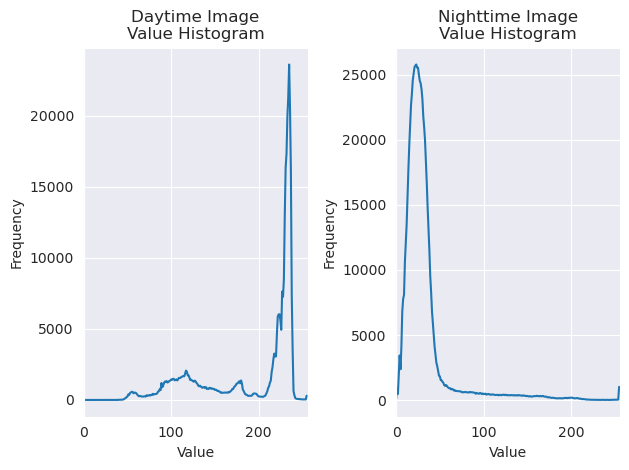

In [3]:
day_img = cv2.imread('assets/images/test/day/20151101_152050.jpg')
night_img = cv2.imread('assets/images/test/night/20151101_072507.jpg')

# Convert to HSV
day_hsv = cv2.cvtColor(day_img, cv2.COLOR_BGR2HSV)
night_hsv = cv2.cvtColor(night_img, cv2.COLOR_BGR2HSV)

# Extract Value channels
day_v = day_hsv[:, :, 2]
night_v = night_hsv[:, :, 2]

# Calculate histograms
day_hist = cv2.calcHist([day_v], [0], None, [256], [0, 256])
night_hist = cv2.calcHist([night_v], [0], None, [256], [0, 256])

# Plot histograms in subplots
plt.figure()

# Daytime Image
plt.subplot(1, 2, 1) 
plt.title("Daytime Image\nValue Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.plot(day_hist)
plt.xlim([0, 256])

# Nighttime Image
plt.subplot(1, 2, 2) 
plt.title("Nighttime Image\nValue Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.plot(night_hist)
plt.xlim([0, 256])

plt.tight_layout() # Adjust layout for better spacing
plt.show()

# Feature Extraction

In [4]:
def compute_histogram(image):
    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Compute the histogram (16 bins for each channel)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [16, 16, 16], [0, 180, 0, 256, 0, 256])
    
    # Normalize the histogram
    cv2.normalize(hist, hist)
    
    # Flatten the histogram to create the feature vector
    return hist.flatten()

In [5]:
def standarized_input(image):
    # resize to w: 1100, h:600
    std_img = cv2.resize(image, (1100,600))

    return std_img

# Training

In [6]:
def load_data(directory):
    data = []
    labels = []
    
    for label in ['day', 'night']:
        path = os.path.join(directory, label)
        for filename in os.listdir(path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(path, filename)
                
                # Read and resize the image
                image = cv2.imread(img_path)
                resized_image = standarized_input(image)
                
                # Compute histogram features
                hist = compute_histogram(resized_image)
                
                # Append features and label
                data.append(hist)
                labels.append(0 if label == 'night' else 1)  # 0 for night, 1 for day
                
    return np.array(data), np.array(labels)

In [7]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Create a pipeline that combines PCA and the classifier
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('svm', SVC)
])

In [8]:
train_data, train_labels = load_data(train_dir)
test_data, test_labels = load_data(test_dir)

In [9]:
print(train_data[0])
print(train_labels[0])

type(train_labels)

[1.2026408e-05 5.6524115e-04 3.3553678e-03 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
1


numpy.ndarray

In [10]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Create a pipeline with PCA and SVM
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('svm', svm.SVC())
])

# Define the parameter grid for GridSearch
param_grid = {
    'pca__n_components': [10, 20, 30, 50, 100, 150],  # Number of PCA components
    'svm__C': [0.1, 1, 10],                 # Regularization parameter for SVM
    'svm__kernel': ['linear', 'rbf']         # Kernel types
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# Fit the model on training data
grid_search.fit(train_data, train_labels)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'pca__n_components': 30, 'svm__C': 1, 'svm__kernel': 'rbf'}
0.9916666666666666


In [11]:
# Get the best model from GridSearch
best_model = grid_search.best_estimator_

# Predict on train data
train_predictions = best_model.predict(train_data)
# Predict on test data
test_predictions = best_model.predict(test_data)

# Evaluate accuracy
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 99.17%
Test Accuracy: 98.12%
